In this first part: we'll be exploring diffrent repositories

### Importing modules

##### some of the tasks are a bit demanding, to be able to see the progess you'll be needing tqdm: pip install tqdm, it's a small package. The program will run normally if it's not install, but you won't be able to see the progres (we tried to handle exceptions, errors won't be raised)

In [1]:
from obspy.clients.fdsn import Client
from tp_obspy_utils import plot_stations
from tp_obspy_utils import plot_events
from obspy import UTCDateTime, read, read_inventory
from tp_obspy_utils import get_periodogram
import re
try:
    from tqdm.notebook import tqdm
    checktqdm = True
except ModuleNotFoundError:
    print("Progress bar won't be shown, please install tqdm: pip install tqdm")
import numpy as np
import matplotlib.pyplot as plt
print("Done...")

Done...


# For this first part, we'll go through multiple repositories


### Getting clients codes and storing them in the "key" variable

In [2]:
keys  = []
codes = []
if checktqdm: pbar0 = tqdm(total=len(keys))  # Init pbar
from obspy.clients.fdsn.header import URL_MAPPINGS
i = 0
for key in sorted(URL_MAPPINGS.keys()):
    i += 1
    if checktqdm: pbar0.update(n=1)  # Increments counter
    keys.append(key)
    codes.append(str(key[:2]))
print(keys)
print("Done...")

['BGR', 'EMSC', 'ETH', 'GEONET', 'GFZ', 'ICGC', 'INGV', 'IPGP', 'IRIS', 'ISC', 'KNMI', 'KOERI', 'LMU', 'NCEDC', 'NIEP', 'NOA', 'ODC', 'ORFEUS', 'RASPISHAKE', 'RESIF', 'SCEDC', 'TEXNET', 'UIB-NORSAR', 'USGS', 'USP']
Done...


### Intialiazing search variables

In [3]:
minlat = 40
maxlat = 45
minlg = 10
maxlg = 15
minmag =6.0
start = UTCDateTime("2016-08-24T01:35:00.000000Z")
end = UTCDateTime("2016-08-24T01:38:30.000000Z")
print("Done...")

Done...


#### Install tqdm before running, it will take a while to fill the inventory object from all these source, tqdm will display a progress bar. for IV network

### Looking for our EQ in each clients repository, getting the events, storing and plotting them

The client's names will be stored be stored in an array

In [4]:
events = []
keepdc = []
if checktqdm: pbar1 = tqdm(total=len(keys))  # Init pbar

for key in keys:
    if checktqdm: pbar1.update(n=1)  # Increments counter
    try:
        temp = Client(key).get_events(
            minlatitude=minlat,
            maxlatitude=maxlat,
            minlongitude=minlg,
            maxlongitude=maxlg,
            minmagnitude=minmag,
            starttime=start,
            endtime=end,
        )
        events.__iadd__(temp)
        
        print("Event found in {} data center".format(str(key)))
        keepdc.append(key)
    except:
        continue
        #print("issue with {}".format(str(key)))
print("Done...")
plot_events(events, origin=[42.7, 13.2], zoom=13)


Event found in EMSC data center
Event found in INGV data center
Event found in IRIS data center
Event found in ISC data center
Event found in ODC data center
Event found in ORFEUS data center
Event found in RESIF data center
Event found in SCEDC data center
Event found in USGS data center
Event found in USP data center
Done...


### Getting stations from diffrent clients  (where the event was found) and networks | CAUTION: this will take a while. Make sure tqdm is installed so you can see the progress.

In [5]:
invall = []
if checktqdm: pbar1 = tqdm(total=len(keepdc))  # Init pbar
for dc in keepdc: #keepdc: clients on whose repositories our event(s) were found
    try:
        if checktqdm: pbar1.update(n=1)  # Increments counter
        client = Client(dc)
        invall.append(client.get_stations(network="*"))
    except:
        if checktqdm: pbar1.update(n=1)  # Increments counter
        continue
print("Done...")

Done...


### Getting and storing station names & codes

In [6]:
station_codes_all = []
stations = []
if checktqdm: pbar1 = tqdm(total=len(invall))  # Init pbar
for inv in invall:
    if checktqdm: pbar1.update(n=1)  # Increments counter
    for net in inv:
        for station in net:
            station_codes_all.append(station.code)
            stations.append([net.code, station.code, station.latitude, station.longitude, station.elevation])
    
print("Done...")

Done...


### Try and plot data from diffrent sources

To avoid long running times, we're not gonna iterate through all the stations 

In [7]:
print("there are {} stations, we won't be able to check all the data, we'll add some restrictions".format(len(station_codes_all)))

there are 68804 stations, we won't be able to check all the data, we'll add some restrictions


###### The next 2 cells were used to explore the data, the first one is to restrict the number of stations to be explored, the seocnd will retrieve the data from the BHZ channel. difrrent channels were tried out as well, this piece of code is the end of the first part where the code was used to explore diffrent datacenters
PS: nothing be plotted after running this cell, we limitted the number of stations so the Jupyter kernel won't be busy for a long period of time unecessarily. Kepp in mind, this piece of code was used as we were progressing was being modified to help us make a choice.

In [8]:
N = 10  # 
usestations = stations[:N]


In [9]:
if checktqdm: pbar = tqdm(total=len(usestations))  # Init pbar
for station in usestations:
    if checktqdm: pbar.update(n=1)  # Increments counter
    try:
        wform = client.get_waveforms(
                        network="*",
                        station= "*",
                        location="*",
                        channel="BHZ",
                        starttime=start,
                        endtime=end,
                        attach_response=True,
            )
        i += 1
        wform.write("./file{}.mseed".format(str(i)+str(station[1])))
        wform1 = read("file{}.mseed".format(str(i)+str(station[1]))) 
        try:
            wform1
        except NameError:
            var_exists = False
        else:
            var_exists = True
        print(var_exists)
        wform1.plot();
    except:
        try:
            wform1
        except NameError:
            var_exists = False
        else:
            var_exists = True
        if not var_exists: N += 1; usestations = stations[:N]
    if N > 200: break
print("Done...")

        


Done...


We narrowed it down, now we shall get to work

### Getting an inventory object for a selection of networks from a set of clients.
##### this could be used for all the clients where the event was detected, just comment the first line, and the variable "keepdc" won't be overwritten 

In [10]:
keepdc = ["INGV","RESIF"] # client selection
net_selection = ['IV','FR']  # network selection
inventory = []
if checktqdm: pbar3 = tqdm(total=len(keepdc))  # Init pbar
for key in keepdc:
    if checktqdm: pbar3.update(n=1)  # Increments counter
    for net in net_selection: 
        client = Client(key)
        try:
            inventory.append(client.get_stations(network=net, level="channel"))
        except: # as you notice some of the excpetion coudln't be handled by the handler, it wasn't recognized,
            # so we're using a general case to stop the program from stopping, the statememnt "raise"..
            # .. was used to get the traceback during troubleshooting
            continue
print("Done...")

Done...


### Station selection

In [11]:
sta_selection = ["PIGN","RM33", "TERO", "GRN"] #station selection

### Getting stations froms selection and plotting.

In [12]:
sta_selected = []

for inv in inventory:
    for network in inv:
        for station in network:
            if station.code in sta_selection:
                sta_selected.append([network.code, station.code, station.latitude, station.longitude, station.elevation])

print("Done...")
plot_stations(sta_selected, origin=[41.8, 13.3], zoom=5, color="#9400D3")

Done...


### Get and plot waveforms - IV network

#### we tried using filters, passing the bp filter coeffcients as an arument in the remove_response method

#### First staion: TERO
Please keep in mind, we used earlier one cell to get all the data from IV, but to get a given recording time for each station we seperated them, there are ways to do so in one cell only, but they'll be more nesting which will run slowly. You'll notice that the first loop iterates only once, that's because elemements can be added easily to the iterator, and useing this exact same code for multiple stations easily. 

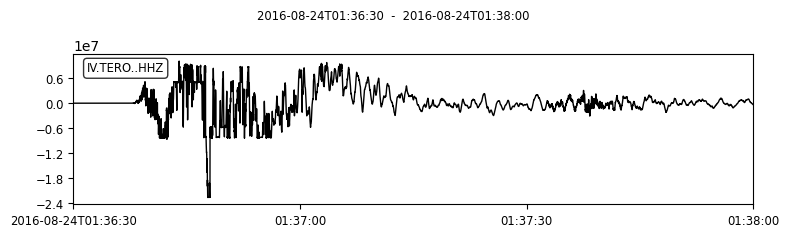

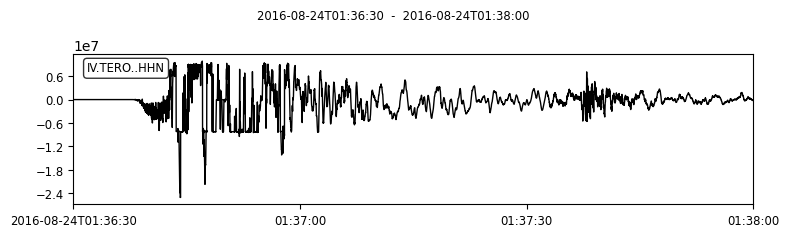

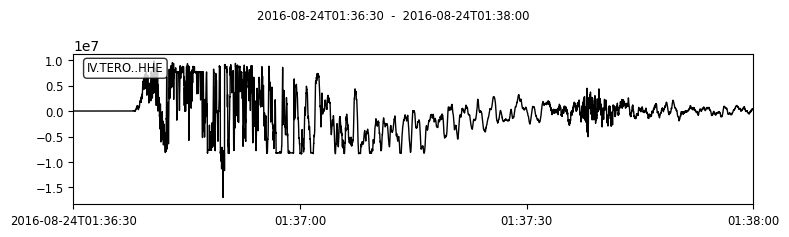

Done...


In [25]:
wform=0
chan_selection = ['HHZ','HHN','HHE']
sta_ingv = ["TERO"]
if checktqdm: pbar = tqdm(total=len(chan_selection))  # Init pbar
    
client = Client("INGV")
for sta in sta_ingv:
    for chan in chan_selection:
        if checktqdm: pbar.update(n=1)  # Increments counter
        try:
            wforma = client.get_waveforms(
                                    network="IV",
                                    station= sta,
                                    location="*",
                                    channel= chan,
                                    starttime=UTCDateTime("2016-08-24T01:36:30.000000Z"),
                                    endtime=UTCDateTime("2016-08-24T01:38:00.000000Z"),
                                    attach_response=True,)

            wforma.write("./{}.mseed".format(str(sta)+str(chan)))
            wform1 = read("{}.mseed".format(str(sta)+str(chan))) 
            wform1.plot()
        except:
            pass
print("Done...")


#### Second staion: PIGN

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


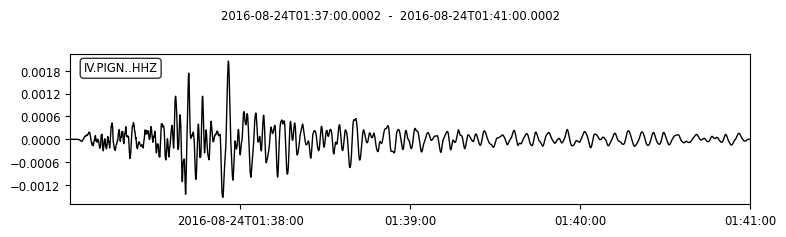

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


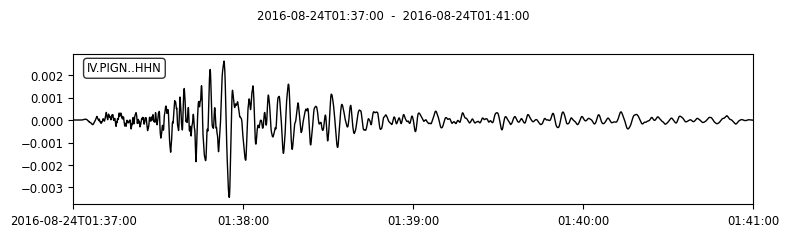

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


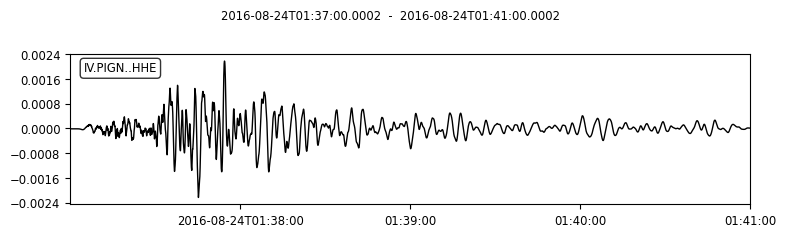

Done...


In [15]:
chan_selection = ['HHZ','HHN','HHE']
sta_ingv = ["PIGN"]
if checktqdm: pbar = tqdm(total=len(chan_selection))  # Init pbar
    
client = Client("INGV")
for sta in sta_ingv:
    for chan in chan_selection:
        if checktqdm: pbar.update(n=1)  # Increments counter
        try:
            wformb = client.get_waveforms(
                                    network="IV",
                                    station= sta,
                                    location="*",
                                    channel= chan,
                                    starttime=UTCDateTime("2016-08-24T01:37:00.000000Z"),
                                    endtime=UTCDateTime("2016-08-24T01:41:00.000000Z"),
                                    attach_response=True,)  
            wformb.remove_response()
            wformb.write("./{}.mseed".format(str(sta)+str(chan)))
            wform1 = read("{}.mseed".format(str(sta)+str(chan))) 
            wform1.plot()
        except:
            pass
print("Done...")


#### Third station: RM33 with no filter

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


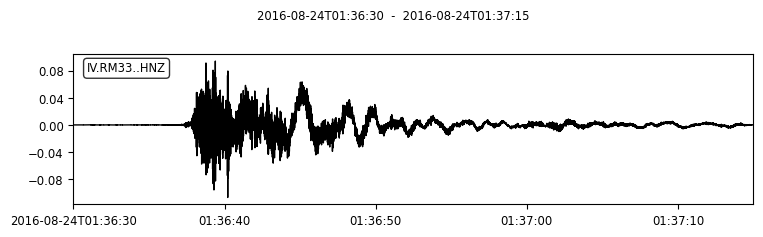

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


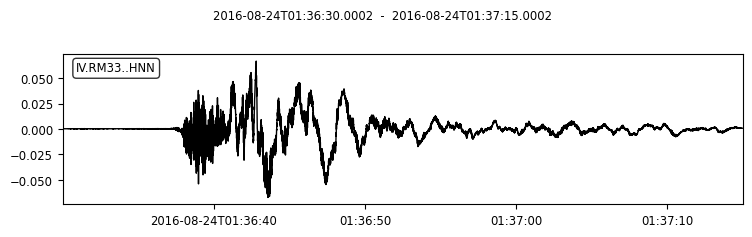

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


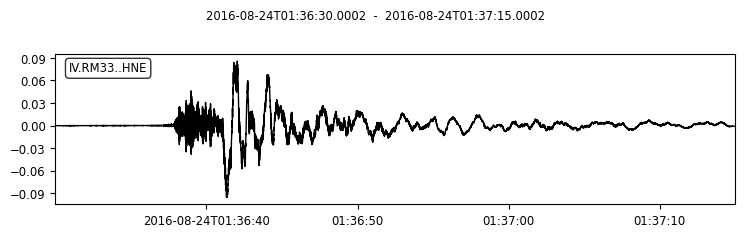

Done...


In [16]:

chan_selection = ['HNZ','HNN','HNE']
sta_ingv = ["RM33"]
if checktqdm: pbar = tqdm(total=len(chan_selection))  # Init pbar
    
client = Client("INGV")
for sta in sta_ingv:
    for chan in chan_selection:
        if checktqdm: pbar.update(n=1)  # Increments counter
        try:
            wformc = client.get_waveforms(
                                    network="IV",
                                    station= sta,
                                    location="*",
                                    channel= chan,
                                    starttime=UTCDateTime("2016-08-24T01:36:30.000000Z"),
                                    endtime=UTCDateTime("2016-08-24T01:37:15.000000Z"),
                                    attach_response=True
                            )
            wformc.remove_response()
            wformc.write("./{}.mseed".format(str(sta)+str(chan)))
            wform1 = read("{}.mseed".format(str(sta)+str(chan))) 
            wform1.plot()
        except:
            pass
print("Done...")

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


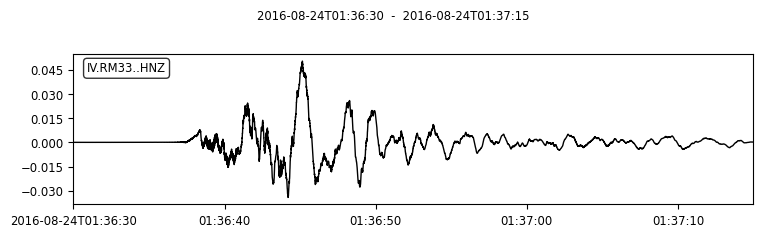

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


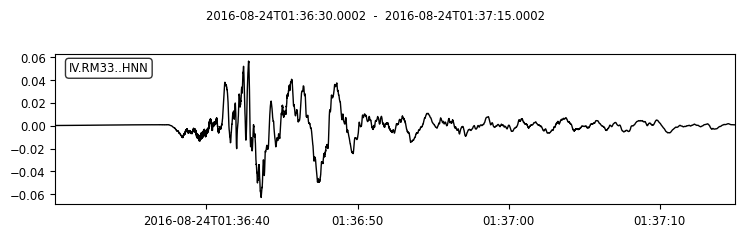

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


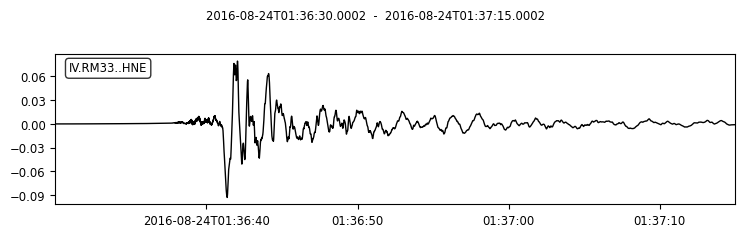

Done...


In [24]:

chan_selection = ['HNZ','HNN','HNE']
sta_ingv = ["RM33"]
if checktqdm: pbar = tqdm(total=len(chan_selection))  # Init pbar
    
client = Client("INGV")
for sta in sta_ingv:
    for chan in chan_selection:
        if checktqdm: pbar.update(n=1)  # Increments counter
        try:
            wformc = client.get_waveforms(
                                    network="IV",
                                    station= sta,
                                    location="*",
                                    channel= chan,
                                    starttime=UTCDateTime("2016-08-24T01:36:30.000000Z"),
                                    endtime=UTCDateTime("2016-08-24T01:37:15.000000Z"),
                                    attach_response=True,
                            )
            pre_filt = (0, 0.1, 45.0, 50.0)
            wformc.remove_response(pre_filt=pre_filt)
            wformc.write("./{}.mseed".format(str(sta)+str(chan)+'filtre'))
            wform1 = read("{}.mseed".format(str(sta)+str(chan)+'filtre')) 
            wform1.plot()
        except:
            pass
print("Done...")

### Get and plot waveforms - FR network
#### Fourth  station: GRN

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


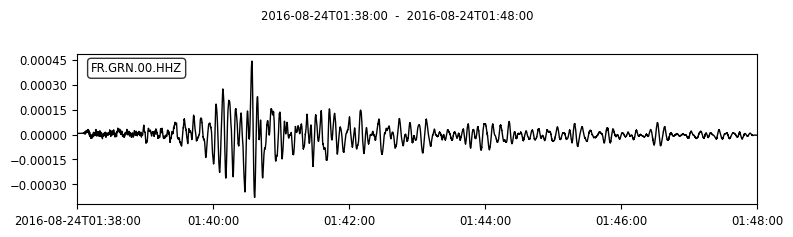

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


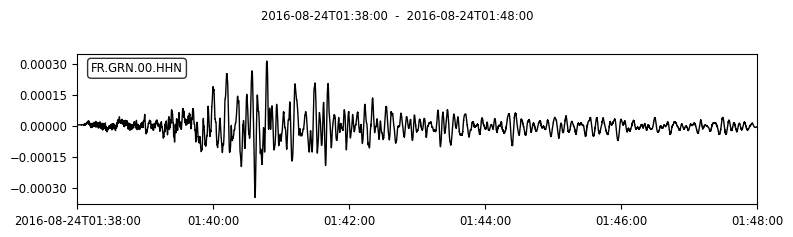

C:\Users\Mustapha\anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


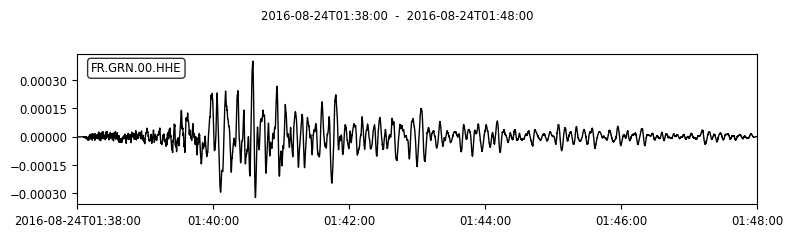

Done...


In [25]:
if checktqdm: pbar = tqdm(total=len(chan_selection))  # Init pbar
chan_selection = ['HHZ','HHN','HHE']   
sta='GRN'
client = Client("RESIF")
for chan in chan_selection:
    if checktqdm: pbar.update(n=1)  # Increments counter
    try:
        wformd = client.get_waveforms(
                                    network="FR",
                                    station= "GRN",
                                    location="*",
                                    channel= chan,
                                    starttime=UTCDateTime("2016-08-24T01:38:00.000000Z"),
                                    endtime=UTCDateTime("2016-08-24T01:48:00.000000Z"),
                                    attach_response=True,
                            )
        wformd.remove_response()
        wformd.write("./{}.mseed".format(str(sta)+str(chan)))
        wform1 = read("{}.mseed".format(str(sta)+str(chan))) 
        wform1.plot()
    except:
        pass
print("Done...")


# working on the data
##### reading data from the downloded files, we used a basic naming convention: station-code+channel-code it's easy to retrieve now.

In [17]:
rm33z = read("RM33HNZ.mseed")
rm33n = read("RM33HNN.mseed")
rm33e = read("RM33HNE.mseed")

teroz = read("TEROHHZ.mseed")
teron = read("TEROHHN.mseed")
teroe = read("TEROHHE.mseed")

pignz = read("PIGNHHZ.mseed")
pignn = read("PIGNHHN.mseed")
pigne = read("PIGNHHE.mseed")

grnz = read("GRNHHZ.mseed")
grnn = read("GRNHHN.mseed")
grne = read("GRNHHE.mseed")
print("Done...")

Done...


### Get spectral density from each of the four signals. 

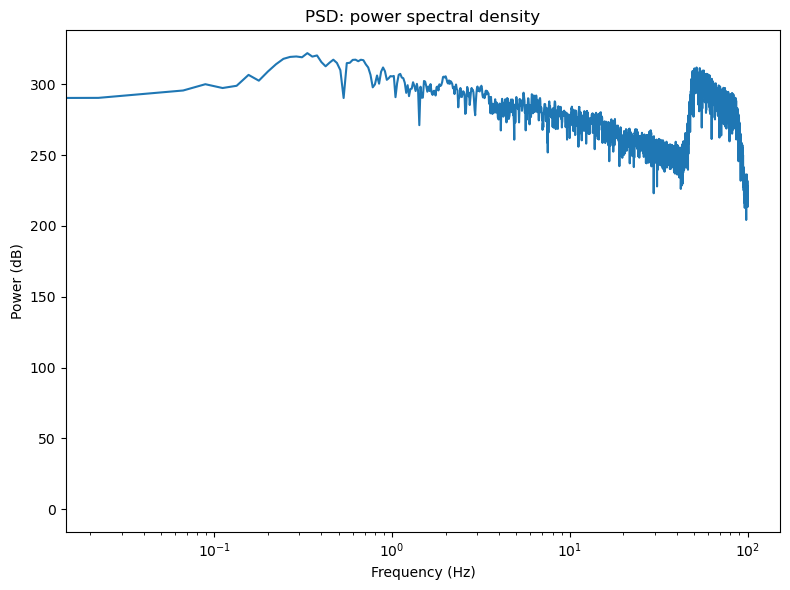

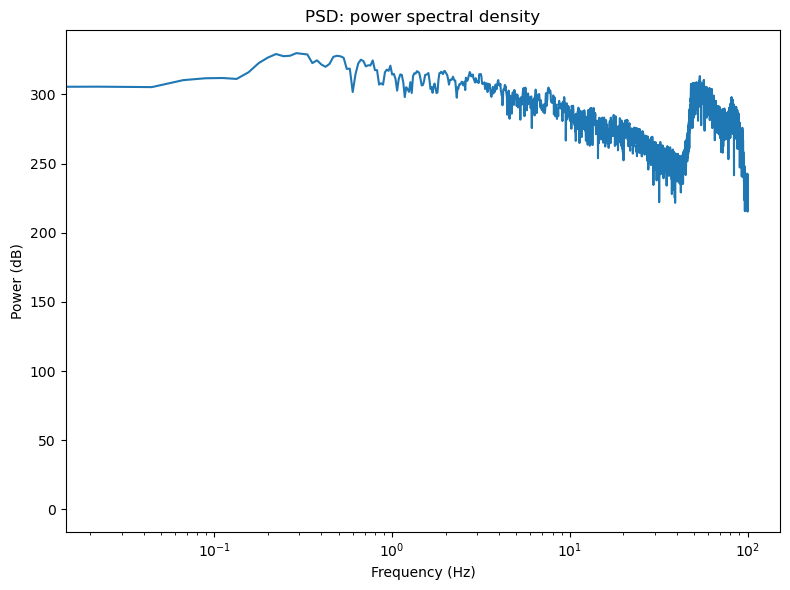

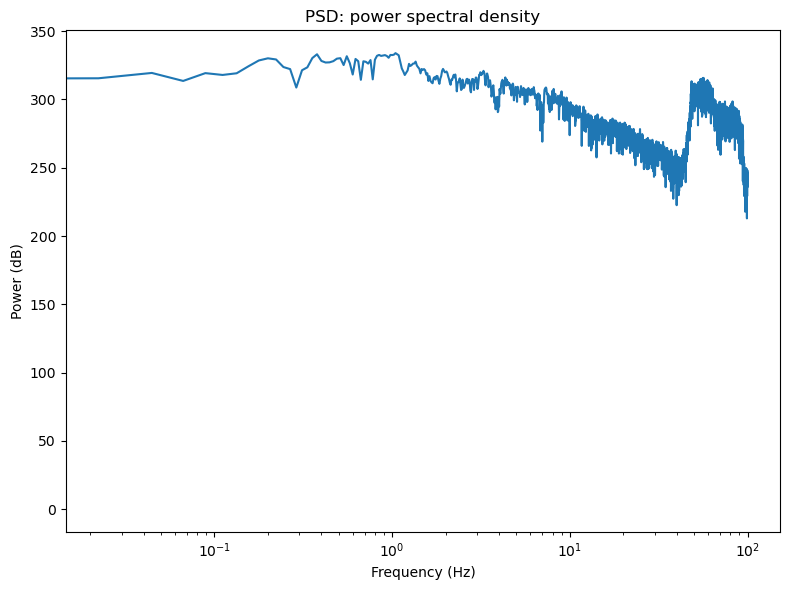

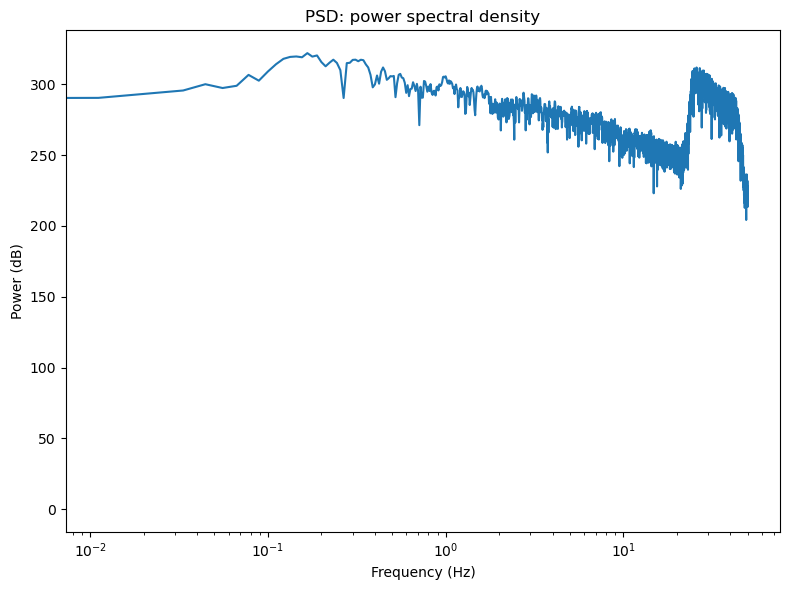

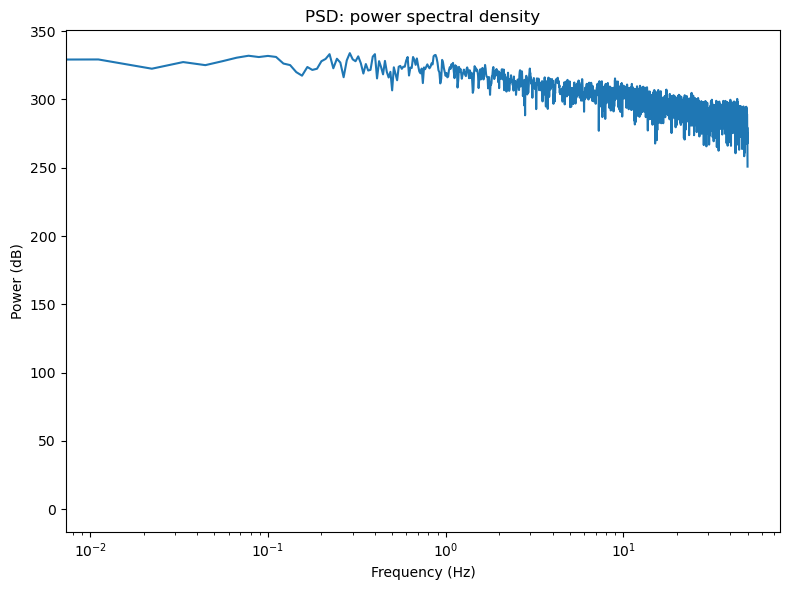

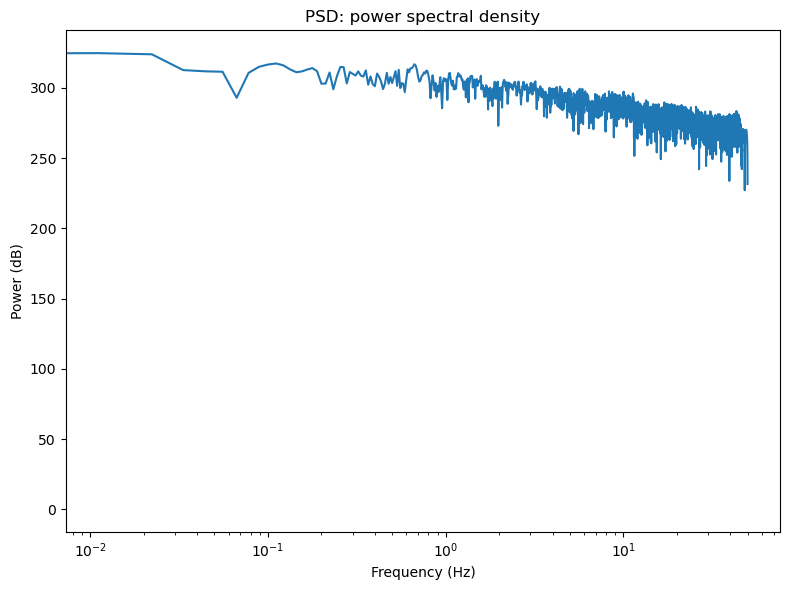

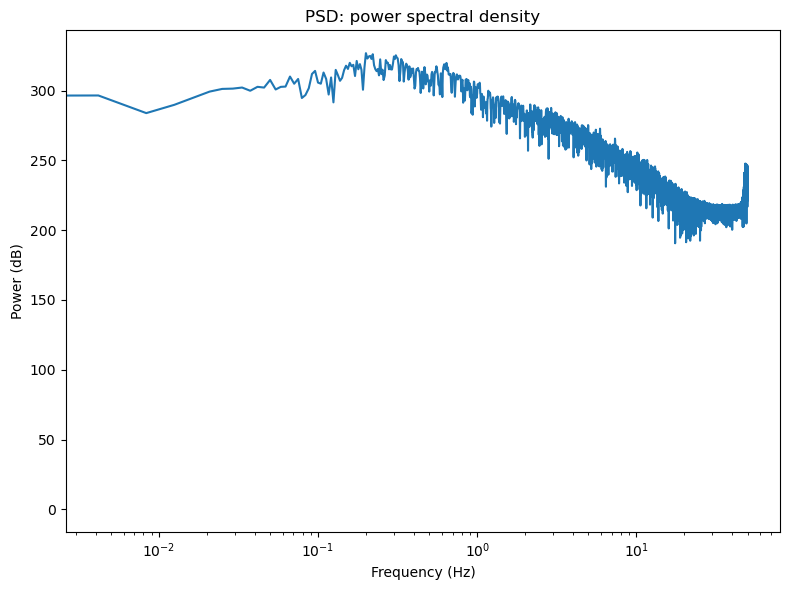

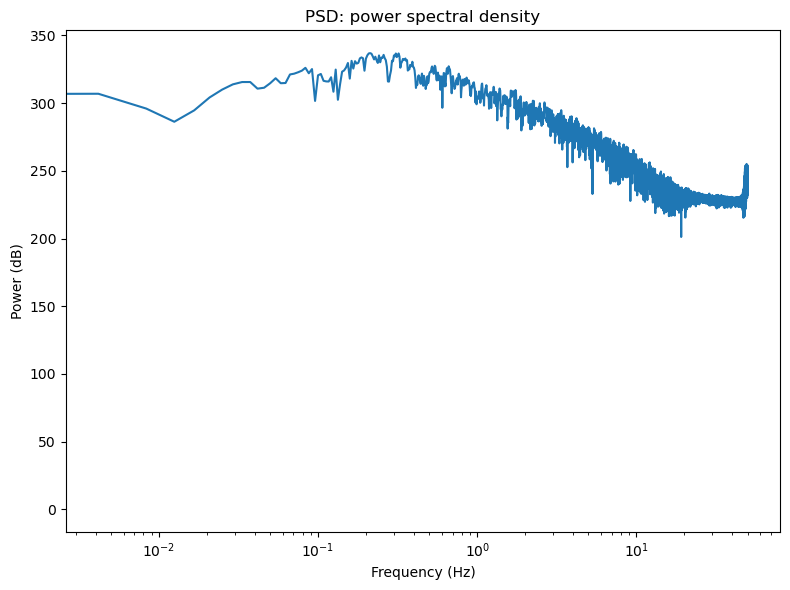

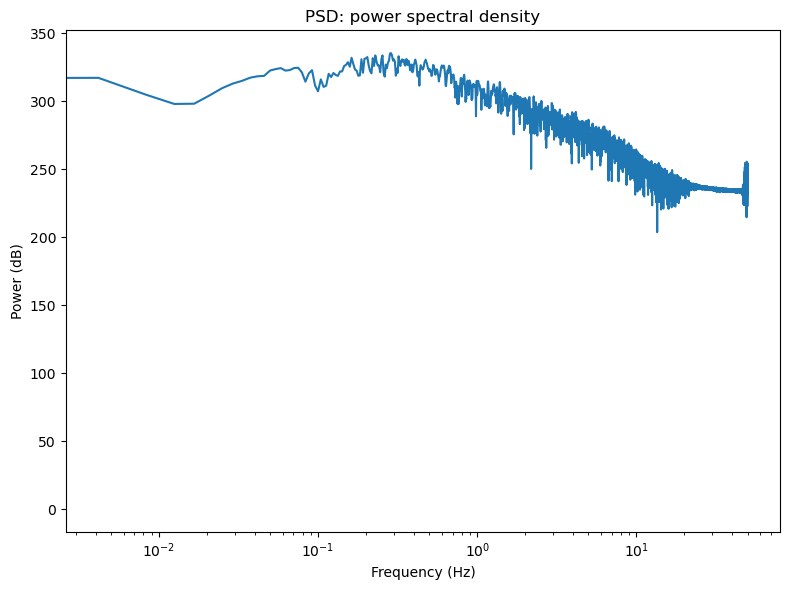

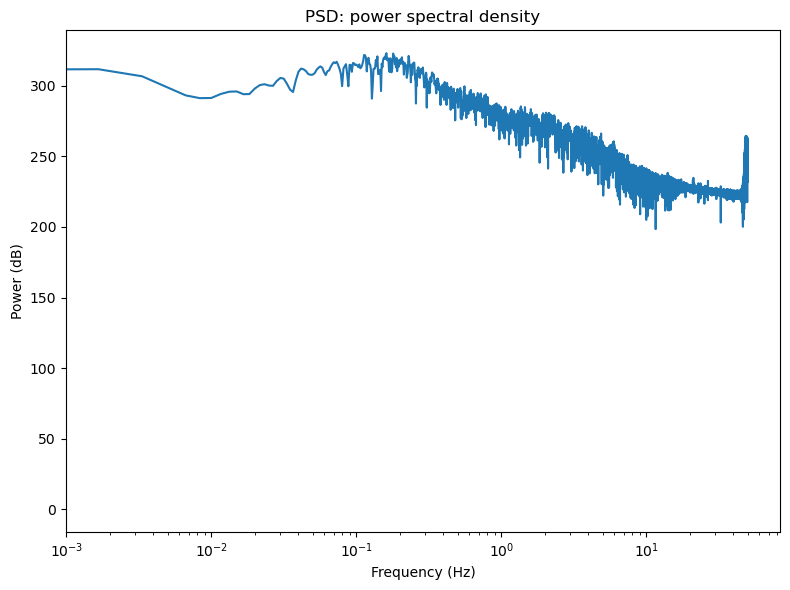

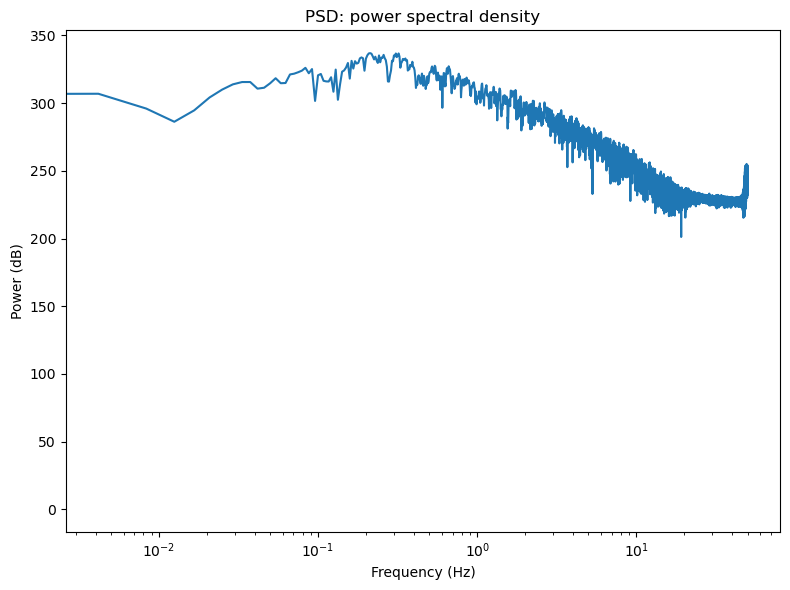

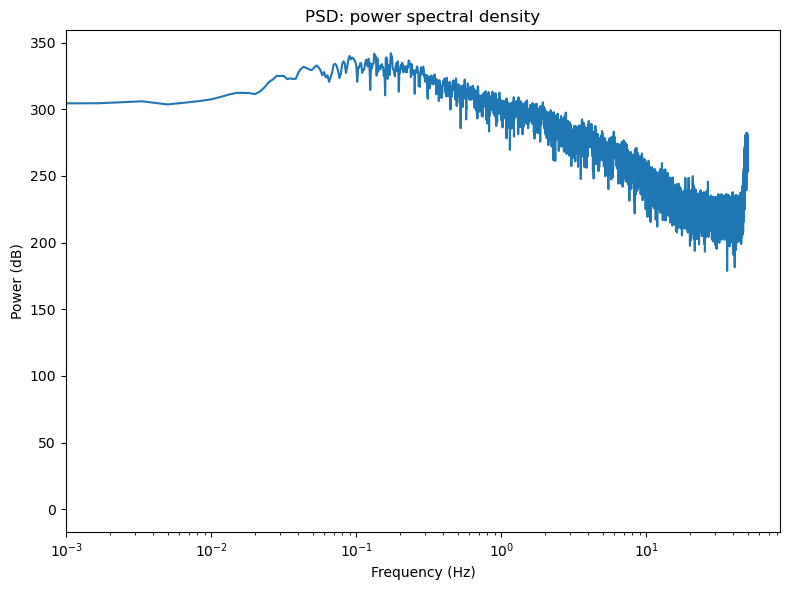

(array([  0.00000000e+00,   1.66663889e-03,   3.33327778e-03, ...,
          4.99958334e+01,   4.99975000e+01,   4.99991667e+01]),
 [0.0,
  304.5573521977051,
  306.00855377684854,
  303.68529819016135,
  305.06536207962813,
  306.2264313185274,
  307.4877110637632,
  309.35649269518655,
  311.1786311030297,
  312.3647988594681,
  312.32380921893247,
  312.1600067621911,
  311.4058131144364,
  313.293464618911,
  316.53250818193555,
  320.45010631984434,
  322.49698855989726,
  325.13124020283146,
  324.9640756890676,
  325.1387547624789,
  322.7006851271949,
  323.1691696667524,
  322.7866508998525,
  322.9073275628904,
  327.77596304168236,
  330.37511472428093,
  331.98293979005507,
  331.1096644343724,
  330.45086827855755,
  329.50274113841084,
  329.857883898555,
  331.8362923751184,
  332.840855584828,
  331.48403871445976,
  329.408035620129,
  325.4780662965659,
  328.02207583857023,
  323.9445108518493,
  325.4842798747029,
  320.63216217375975,
  324.18315317478795,
  328.12

In [18]:
### RM33
rm33zSpec = rm33z[0].data
sampling_rate = rm33z[0].stats.sampling_rate
get_periodogram(
    rm33zSpec, fs=sampling_rate, semilog=True, show=True
)

rm33nSpec = rm33n[0].data
sampling_rate = rm33n[0].stats.sampling_rate
get_periodogram(
    rm33nSpec, fs=sampling_rate, semilog=True, show=True
)

rm33eSpec = rm33e[0].data
sampling_rate = rm33e[0].stats.sampling_rate
get_periodogram(
    rm33eSpec, fs=sampling_rate, semilog=True, show=True
)

### TERO

terozSpec = rm33z[0].data
sampling_rate = teroz[0].stats.sampling_rate
get_periodogram(
    terozSpec, fs=sampling_rate, semilog=True, show=True
)

teronSpec = teron[0].data
sampling_rate = teron[0].stats.sampling_rate
get_periodogram(
    teronSpec, fs=sampling_rate, semilog=True, show=True
)

teroeSpec = teroe[0].data
sampling_rate = teroe[0].stats.sampling_rate
get_periodogram(
    teroeSpec, fs=sampling_rate, semilog=True, show=True
)

### PIGN

pignzSpec = pignz[0].data
sampling_rate = pignz[0].stats.sampling_rate
get_periodogram(
    pignzSpec, fs=sampling_rate, semilog=True, show=True
)

pignnSpec = pignn[0].data
sampling_rate = pignn[0].stats.sampling_rate
get_periodogram(
    pignnSpec, fs=sampling_rate, semilog=True, show=True
)

pigneSpec = pigne[0].data
sampling_rate = pigne[0].stats.sampling_rate
get_periodogram(
    pigneSpec, fs=sampling_rate, semilog=True, show=True
)

### GRN

grnzSpec = grnz[0].data
sampling_rate = grnz[0].stats.sampling_rate
get_periodogram(
    grnzSpec, fs=sampling_rate, semilog=True, show=True
)

grnnSpec = pignn[0].data
sampling_rate = grnn[0].stats.sampling_rate
get_periodogram(
    grnnSpec, fs=sampling_rate, semilog=True, show=True
)

grneSpec = grne[0].data
sampling_rate = grne[0].stats.sampling_rate
get_periodogram(
    grneSpec, fs=sampling_rate, semilog=True, show=True
)



## Reading, detrending and plotting the time series

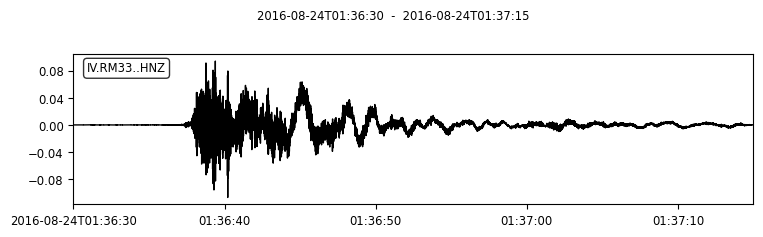

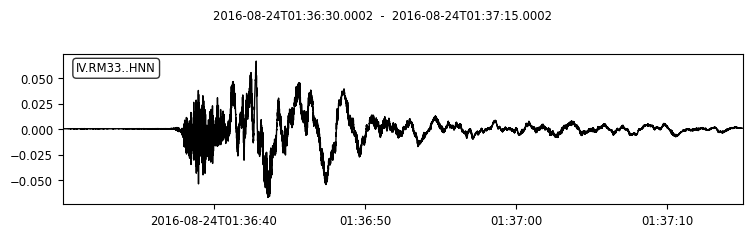

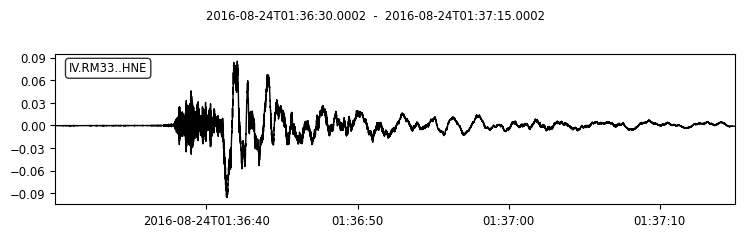

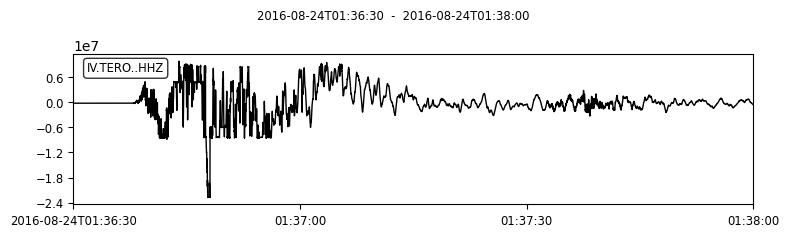

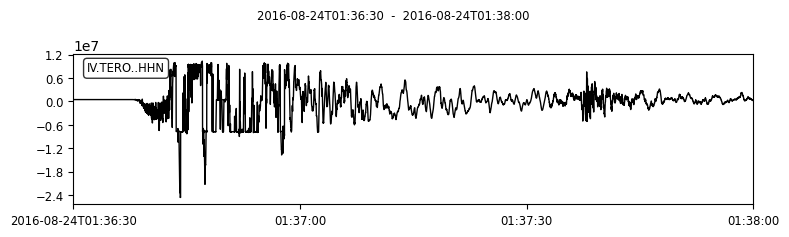

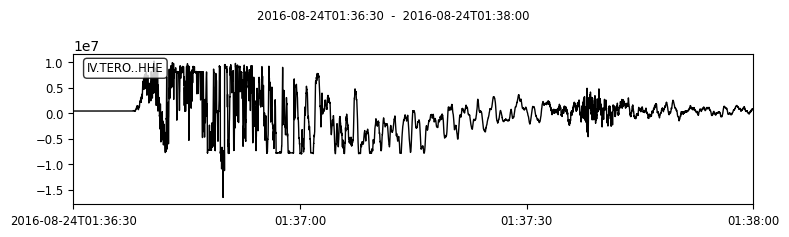

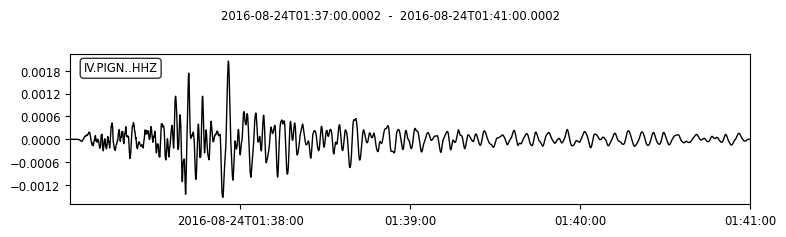

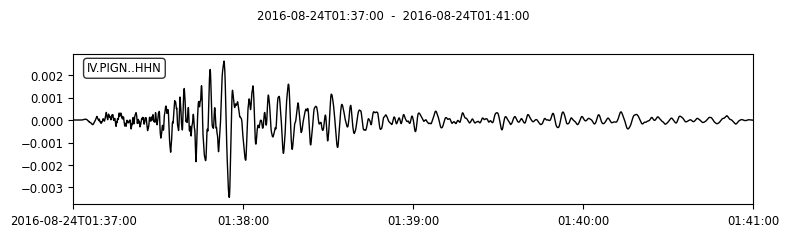

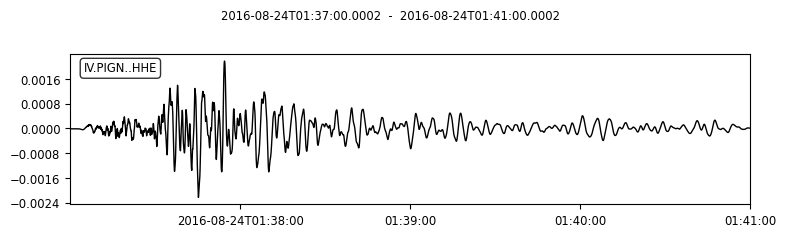

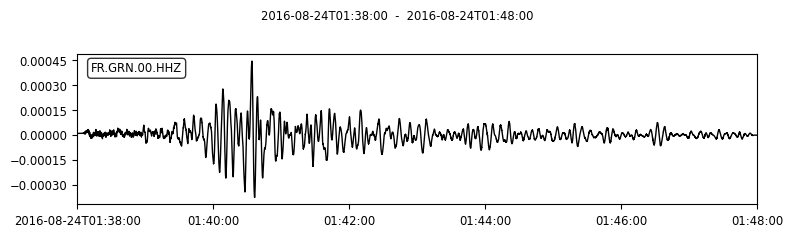

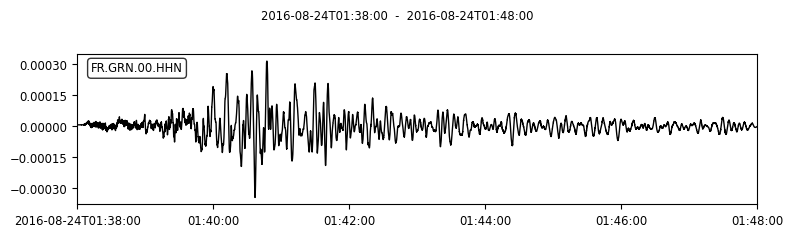

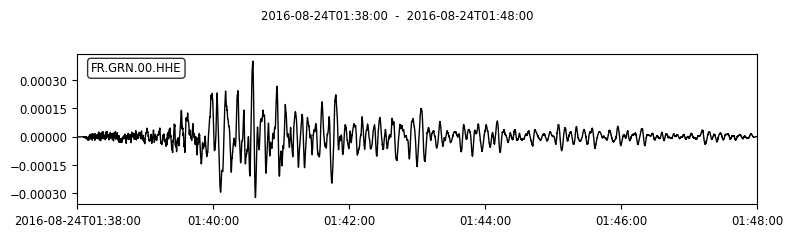

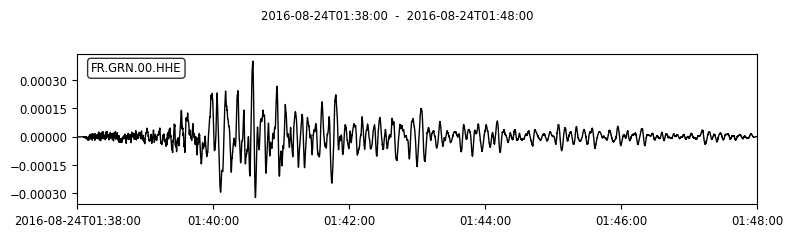

In [26]:
## Read the miniseed file and detrend:

#RM33
rm33z.detrend("demean")
rm33n.detrend("demean")
rm33e.detrend("demean")

rm33z.plot()
rm33n.plot()
rm33e.plot()

#TERO 
teroz.detrend("demean")
teron.detrend("demean")
teroe.detrend("demean")

teroz.plot()
teron.plot()
teroe.plot()

#PIGN
pignz.detrend("demean")
pignn.detrend("demean")
pigne.detrend("demean")

pignz.plot()
pignn.plot()
pigne.plot()

#GRN
grnz.detrend("demean")
grnn.detrend("demean")
grne.detrend("demean")

grnz.plot()
grnn.plot()
grne.plot()







## Calculating the Fourier transform of the signals:

Text(0.5, 1.0, 'Frequency spectrum')

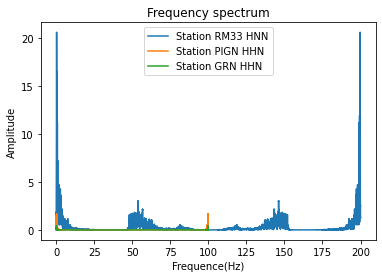

In [19]:
#calculate the Fourier transform of the "North" direction signals
dt1=(rm33n[0].stats.endtime-rm33n[0].stats.starttime)/len(rm33n[0])
T1=(rm33n[0].stats.endtime-rm33n[0].stats.starttime)

dt2=(pignn[0].stats.endtime-pignn[0].stats.starttime)/len(pignn[0])
T2=(pignn[0].stats.endtime-pignn[0].stats.starttime)

dt3=(grnn[0].stats.endtime-grnn[0].stats.starttime)/len(grnn[0])
T3=(grnn[0].stats.endtime-grnn[0].stats.starttime)

a=abs(np.fft.fft(rm33n[0]))
b=abs(np.fft.fft(pignn[0]))
c=abs(np.fft.fft(grnn[0],60002))

afreq=np.arange(0,1/dt1,1/T1)
bfreq=np.arange(0,1/dt2,1/T2)
cfreq=np.arange(0,1/dt3,1/T3)



plt.figure()
plt.plot(afreq,a,label='Station RM33 HNN')
plt.plot(bfreq,b,label='Station PIGN HHN')
plt.plot(cfreq,c,label='Station GRN HHN')
plt.legend(loc='upper center')
plt.xlabel('Frequence(Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency spectrum')


## Calculate the energy

In [20]:
#calculate the energy of the time signals
at=0
for i in range(len(rm33n[0])):
  at=at+(rm33n[0][i])**2
for i in range(len(rm33e[0])):
  at=at+(rm33e[0][i])**2
for i in range(len(rm33z[0])):
  at=at+(rm33z[0][i])**2
bt=0
for i in range(len(pignn[0])):
  bt=bt+(pignn[0][i])**2
for i in range(len(pigne[0])):
  bt=bt+(pigne[0][i])**2
for i in range(len(pignz[0])):
  bt=bt+(pignz[0][i])**2
ct = 0
for i in range(len(grnn[0])):
  ct = ct + (grnn[0][i])**2
for i in range(len(grne[0])):
  ct = ct + (grne[0][i])**2
for i in range(len(grnz[0])):
  ct = ct + (grnz[0][i])**2

print('Signal Energy of RM33HN = '+str(at))
print('Signal Energy of PIGNHH= '+str(bt))
print('Signal Energy of GRNHH = '+str(ct))
plt.show()

Signal Energy of RM33HN = 4.40448084581
Signal Energy of PIGNHH= 0.0110585873652
Signal Energy of GRNHH = 0.000649542677231
